# Geometric Generator Models

In this tutorial, we'll explore the geometric network generator models
implemented under [`networkx/generators/geometric.py`](https://github.com/networkx/networkx/blob/main/networkx/generators/geometric.py) and apply them
to a real-world use case to learn how these models can be parameterized and used.

## Import packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Geometric/Spatial Networks

Many real-world complex systems have spatial components constraining the
network structures these types of systems can produce.
Infrastructure networks such as transportation, electrical, and
telecommunication systems, social networks and even our own synaptic networks
are all embedded in physical space.
Spatial Networks provide a framework for network models having spacial elements
where nodes are embedded in space and a metric is incorporated that dictates
the conditions for connection between nodes.
Typically, the probability of connection is a decreasing function of the
metric, with most models assuming Euclidean distance in 2-dimensions or 3-dimensions.
The intuition of most Spatial Network models propose that there exists an
increasing cost of connection between nodes that are further apart, though
arbitrary connection probability functions can be modeled.

The potential application of Spatial Networks to such a wide variety of
real-world systems has motivated substainial research into these networks,
with many unique but closely related models being proposed with theoretical
proofs for many of their network properties.
The 2010 Spatial Networks review article by Marc Barthélemy [^1] provides a
comprehensive overview of the field and reviews many of the most important
theoretical proofs for the most common Spatial Network models.
Here we explore some of the most typical Spatial Network models which have been
implemented in the networkx package.
These models can be classified using only three model parameters used by these
different models:


 - $R$ - The maximum connection distance, the `radius` parameter in networkx
 - $P(d_{ij})$ - The probability of edge connection as a function of the
   distance, $d_{ij}$, between nodes $i, j$ where $i \neq j$, the `p_dist`
   parameter in networkx
 - $\theta$ - The node weight threshold for connection, the `theta` parameter
   in networkx

Typically, nodes are uniformly distributed onto the unit square and node weights
are sampled from some weight distribution.
Distance, $d_{ij}$ is typically assumed to be the Euclidean distance,
but some networkx models allow custom metrics where others only allow Minkowski
distance metrics.

The figure below shows the relationships between Spatial Network Models
connected by their shared parameterization.

![spatial_networks](images/spatial_networks.png "Spatial Networks")

### Individual Model Definitions

This section summarizes the various models. The notation $E_{ij}$
indicates an edges exists between nodes $i$ and $j$.

#### Random Geometric Graphs ($R$)

A d-dimensional Random Geometric Graph (RGG) is a graph where each of the $N$
nodes is assigned random coordinates in the box $[0, 1]^{d}$, and only
nodes "close" to each other are connected by an edge [^2].
Any node within or equal to the maximum connection distance, $R$, is a connected
node and the structure of the network is fully defined by $R$.
RGGs, similar to Unit Disk Graphs [^3],  have been widely used to model ad-hoc
wireless networks.

$$ E_{ij}: d_{ij} \leq R $$

#### Waxman Graphs ($\alpha$)

Waxman Graphs are the spatial generalization of Erdős–Rényi random graphs, where the
probability of connection of nodes depends on a function of the distance between them[^4].
The original edge probabiliy function proposed by Waxman is exponential in
$d_{ij}$, providing two connection probability tuning parameters, $\alpha$ and $\beta$:

$$ P(d_{ij}) = \beta e^{\frac{-d_{ij}}{L \alpha}} $$ 

Where $L$ is the maximum distance between each pair of nodes.

The shape of the edge probabiliy function, $P(d_{ij})$, plays the key role
in determining the structure of a Waxman graph, but characterization of
$P(d_{ij})$ in real-world networks still seems controversial.
The most commonly studied functional families are the orginal exponential above,
or power laws, $-{d_{ij}}^{-\alpha}$.

$$ E_{ij} \propto P(d_{ij}) $$

#### Threshold Graphs ($\theta$)

A simple graph G is a threshold graph if we can assign weights to the vertices
such that a pair of distinct vertices is adjacent exactly when the sum of their
assigned weights equals or exceeds a specified threshold, $\theta$ [^6].
Threshold Graphs are not themselves Spatial Networks, as they do not incorporate
a specific geometry or metric, but they introduce the ability to consider node
weights as part of the network model which is utilized by other Spatial Network
models such as Geometric Threshold Graphs.

$$ E_{ij}: (w_i + w_j) \geq \theta $$

#### Geographical Threshold Graphs ($P(d_{ij}), \theta$)

Geographical Threshold Graphs are the geographical generalization of Threshold
Graphs, where a pair of vertices with weights $w_i, w_j$,
and distance $d_{ij}$ are connected if and only if the product between
the sum of weights  $w_i$ and $w_j$ with the edge connection
function, $P(d_{ij})$, is greater than or equal to a threshold value, $\theta$. [^8]

$$ E_{ij}: (w_i + w_j) P(d_{ij}) \geq \theta $$

#### Soft Random Geometric Graphs ($R, P(d_{ij})$)

A recent extention of Random Geometric Graphs couples the influence of distance
between nodes that are within the maximum connection distance, $R$, to better model
real-world systems where node proximity does not necessarily guarantee a
connection between "close" nodes.
In Soft Random Geometric Graphs, the probability  of connection between nodes $i$
and $j$ is a function of their distance, $d_{ij}, if $d_{ij} \leq R$.
Otherwise, they are disconnected [^7].

$$ E_{ij} \propto P(d_{ij}) \textrm{ if } d_{ij} \leq R $$

#### Thresholded Random Geometric Graphs ($R, \theta$)

Thresholded Random Geometric Graphs extend RGGs to incorporate node weights into
the model, where connections are only made between nodes with sufficiently
powerful weights, up to a maximum connection distance between nodes [^9].

$$ (w_i + w_j) \geq \theta \textrm{ if } d_{ij} \leq R $$

### A Motivating Example

For this tutorial, we'll use the Tesla North American Supercharger network to
highlight how the various spatial network models implemented in networkx can
be parameterized and used.

![spatial_networks](images/NA-Supercharger_Network.jpg "Tesla Supercharger Network")

The Supercharger data is obtained from supercharger.info, filtered for the
Canadian and American Supercharger locations, totaling 385 Opened Superchargers
as of April 2017.
The collected data has been structured into a Networkx Graph which is made up of
nested dictionaries keyed on the geohash of each Supercharger's GPS coordinates
which have been converted into a projected embedding onto the unit square.
Node weights are the population of cities for each Supercharger, as a percent
of total North American population.
With this dataset, we can model the supercharger network with the various spatial
networks implemented in networkx.

In [2]:
# Some matplotlib settings
mpl_params = {
    "axes.titlesize": 20,
    "figure.figsize": (12, 4),
}
plt.rcParams.update(mpl_params)

Next, we load the data and construct the graph.

In [3]:
# from networkx.readwrite import json_graph
import json

# load json-ed networkx datafile
with open("data/tesla_network.json") as infile:
    G = nx.json_graph.node_link_graph(json.load(infile), edges="links")

In [4]:
print(G)

Graph with 385 nodes and 0 edges


In [5]:
# example node data structure keyed on geohash of GPS cords
G.nodes["dr7k46ycwwb8"]

{'SC_index': 173,
 'geohash': 'dr7k46ycwwb8',
 'weight': 0.00014093906625032375,
 'GPS_lon_lat': [-74.07126104459167, 41.49977498687804],
 'lat': 41.49977498687804,
 'lon': -74.07126104459167,
 'population': 28101,
 'pos': [0.8123107474668945, 0.42622282744786055],
 'GPS': [41.49977498687804, -74.07126104459167]}

In [6]:
# extract pos and weight attributes for use in models
nodes = G.nodes()
pos = nx.get_node_attributes(G, "pos")
weight = nx.get_node_attributes(G, "weight")

Since we'll be visualizing a lot of graphs, let's define some general
plotting options for consistent visualizations.

In [7]:
node_opts = {"node_size": 50, "node_color": "r", "alpha": 0.4}
edge_opts = {"edge_color": "k"}

## Random Geometric Graphs

For RGGs, we see the impact of increasing the maximum connection distance
parameter `radius` in increasing the number of connections.

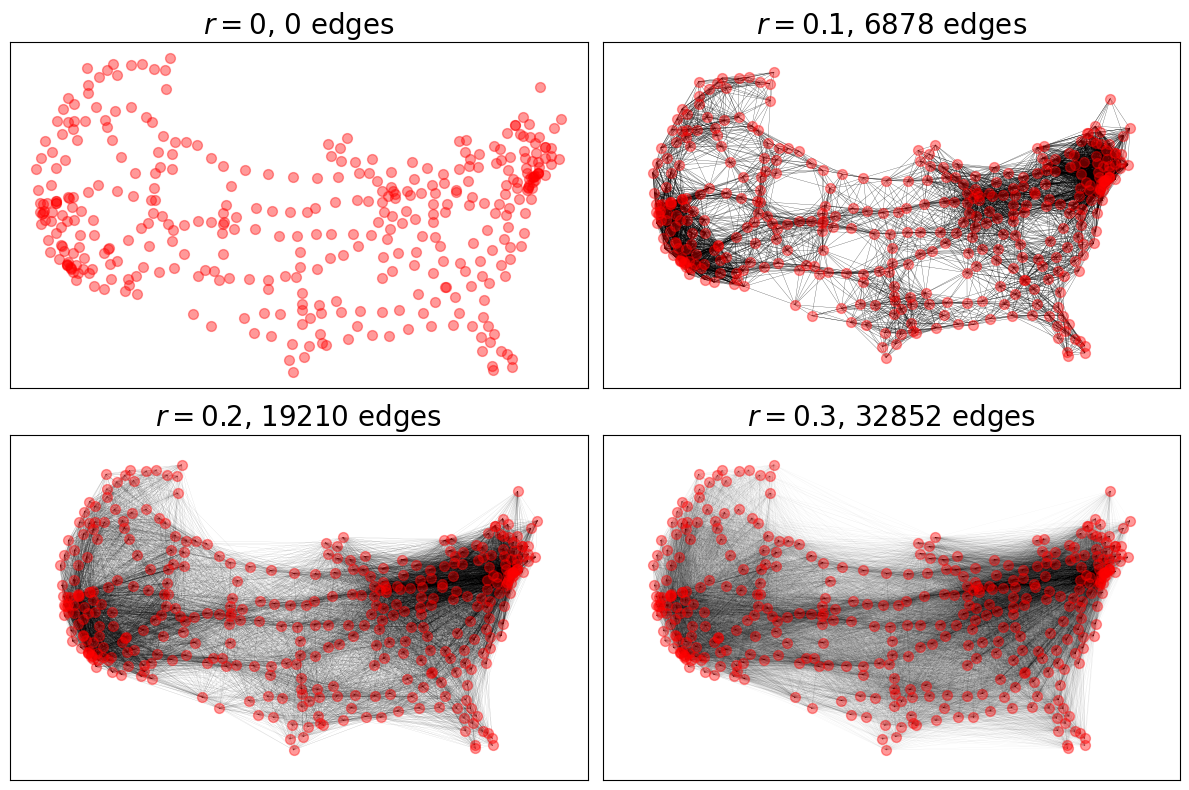

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# Params for visualizing edges
alphas = (0.8, 0.8, 0.3, 0.1)
linewidths = (0.2, 0.2, 0.1, 0.1)

radii = (0, 0.1, 0.2, 0.3)
for r, ax, alpha, lw in zip(radii, axes.ravel(), alphas, linewidths):
    RGG = nx.random_geometric_graph(nodes, radius=r, pos=pos)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(RGG, pos=pos, ax=ax, alpha=alpha, width=lw, **edge_opts)
    ax.set_title(f"$r = {r}$, {RGG.number_of_edges()} edges")
fig.tight_layout()

In [9]:
# Make edge visualization more prominent (and consistent) for the following
# examples
edge_opts["alpha"] = 0.8
edge_opts["width"] = 0.2

## Geographical Threshold Graphs

The GTG model allows for a wide range of custom parameters including custom node
positioning, weights, and a metric between nodes and the probability of connection,
$P(d_{ij})$.
The default $P(d_{ij})$ model is the metric value, $r$, for the two connecting
nodes raised to the $-\alpha$ parameter, which has a default value of 2.

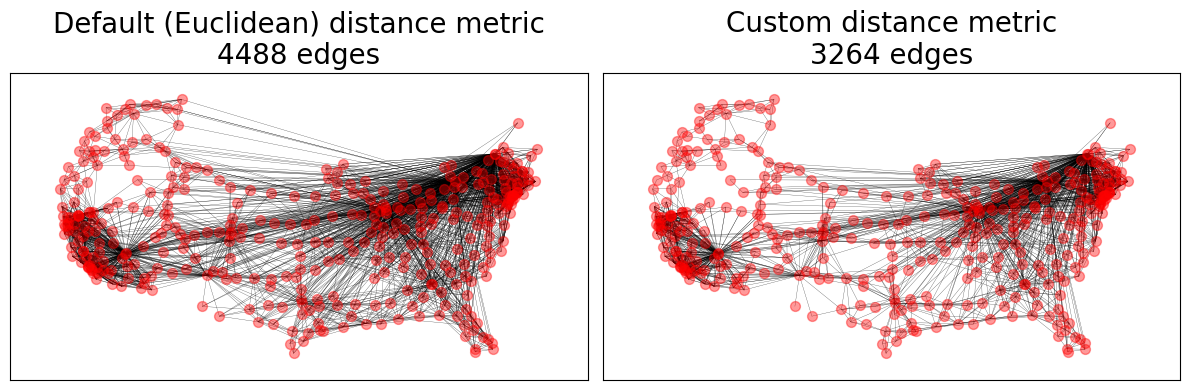

In [10]:
fig, axes = plt.subplots(1, 2)

# Custom distance metric
dist = lambda x, y: sum(abs(a - b) for a, b in zip(x, y))

distance_metrics = {
    "Default (Euclidean) distance metric": None,  # Euclidean distance
    "Custom distance metric": dist,
}

for (name, metric), ax in zip(distance_metrics.items(), axes.ravel()):
    GTG = nx.geographical_threshold_graph(
        nodes, 0.1, pos=pos, weight=weight, metric=metric
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(GTG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"{name}\n{GTG.number_of_edges()} edges")
fig.tight_layout()

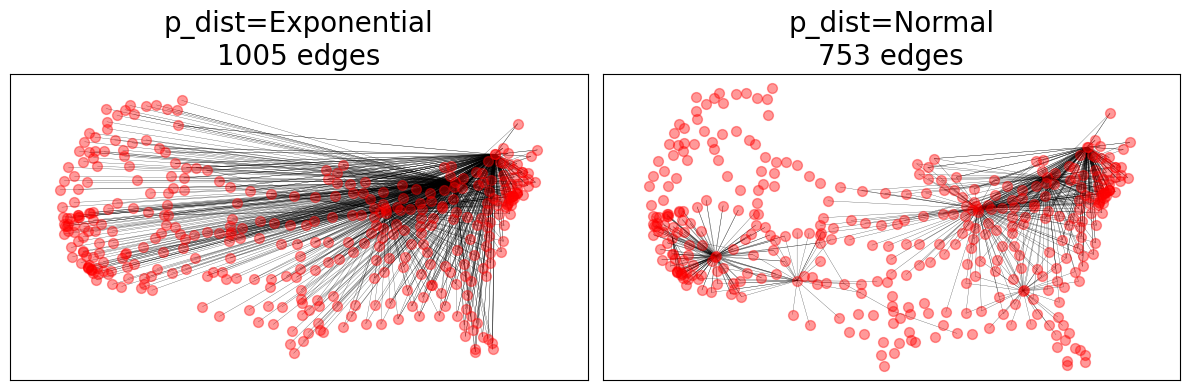

In [11]:
fig, axes = plt.subplots(1, 2)

# Evaluate different p_dists
import math
from scipy.stats import norm

p_dists = {
    "p_dist=Exponential": lambda d: math.exp(-d),
    "p_dist=Normal": norm(loc=0.1, scale=0.1).pdf,
}

for (name, p_dist), ax in zip(p_dists.items(), axes.ravel()):
    GTG = nx.geographical_threshold_graph(
        nodes, 0.01, pos=pos, weight=weight, metric=dist, p_dist=p_dist
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(GTG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"{name}\n{GTG.number_of_edges()} edges")
fig.tight_layout()

## Soft Random Geometric Graphs

SRGGs utilize the maximum connection distance parameter, $R$, of RGGs but provide
the ability to input an arbitrary connection probability function, $P(d_{ij})$,
for nodes within the maximum connection distance.
The default $P(d_{ij})$ function for SRGGs in networkx is an exponential
distribution with rate parameter `lambda=1`.

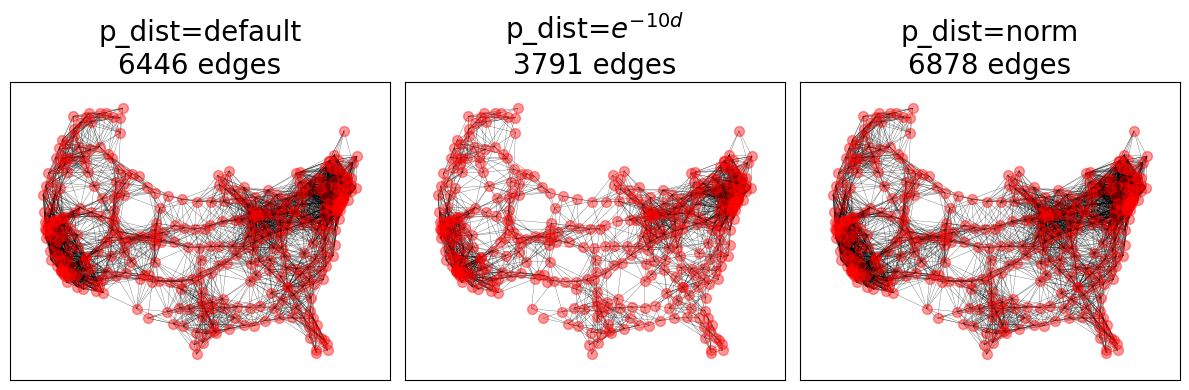

In [12]:
fig, axes = plt.subplots(1, 3)

pdfs = {
    "default": None,  # default: exponential distribution with `lambda=1`
    r"$e^{-10d}$": lambda d: math.exp(-10 * d),
    "norm": norm(loc=0.1, scale=0.1).pdf,
}
for (title, pdf), ax in zip(pdfs.items(), axes.ravel()):
    SRGG = nx.soft_random_geometric_graph(nodes, 0.1, pos=pos, p_dist=pdf)
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(SRGG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"p_dist={title}\n{SRGG.number_of_edges()} edges")
fig.tight_layout()

## Thresholded Random Geometric Graphs

TRGGs allow for the coupling of the maximum connection distance and threshold parameters.
The default weights for TRGG are drawn from an exponential distribution with
rate parameter `lambda=1`.

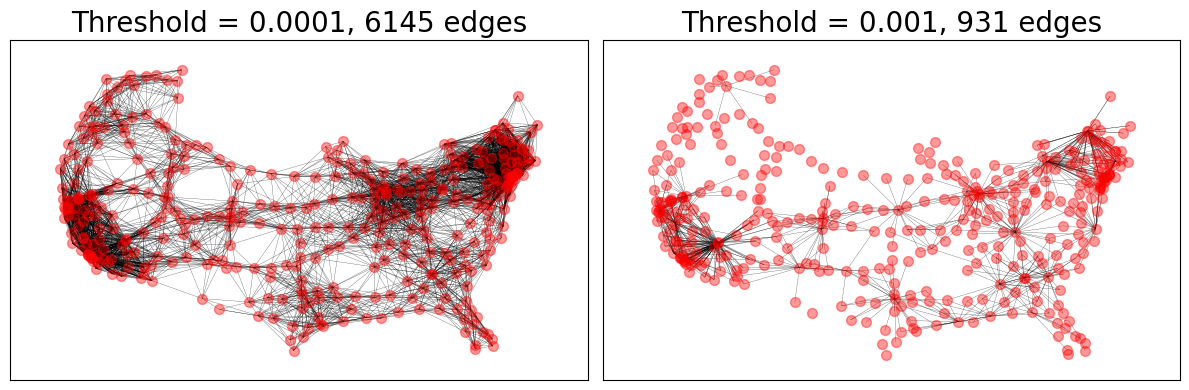

In [13]:
fig, axes = plt.subplots(1, 2)

# Increased threshold parameter, theta, reduces graph connectivity
thresholds = (0.0001, 0.001)
for thresh, ax in zip(thresholds, axes):
    TRGG = nx.thresholded_random_geometric_graph(
        nodes, 0.1, thresh, pos=pos, weight=weight
    )
    nx.draw_networkx_nodes(G, pos=pos, ax=ax, **node_opts)
    nx.draw_networkx_edges(TRGG, pos=pos, ax=ax, **edge_opts)
    ax.set_title(f"Threshold = {thresh}, {TRGG.number_of_edges()} edges")
fig.tight_layout()

## References

[^1]: Spatial Networks <https://doi.org/10.1016/j.physrep.2010.11.002>

[^2]: Random Geometric Graphs <https://doi.org/10.1103/PhysRevE.66.016121>

[^3]: Unit Disk Graphs <https://doi.org/10.1016/0012-365X(90)90358-O>

[^4]: Waxman Graphs <https://doi.org/10.1109/49.12889>

[^6]: Threshold Graphs - <https://doi.org/10.37236/219>

[^7]: Soft Geometric Random Graphs - <https://doi.org/10.1214/15-AAP1110>

[^8]: Geometric Threshold Graphs - <https://doi.org/10.1103/PhysRevE.71.036108>

[^9]: Thresholded Random Geometric Graphs - <http://hdl.handle.net/2117/111425>